Import tensorflow and other modules.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from sklearn.metrics import classification_report,confusion_matrix
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

ModuleNotFoundError: No module named 'tensorflow'

Download and seperate dataset into training and validation.

In [ ]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True,
    split=['train[:70%]', 'train[70%:]'],
)

Print information about dataset.

In [ ]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Create new modle architecture using pretrained inception model.

In [ ]:
IMAGE_RES = 299

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


Compile new model.

In [ ]:
model_inception.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Train new model.

In [ ]:
EPOCHS = 6
BATCH_SIZE = 32

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 21s 190ms/step - loss: 0.7554 - accuracy: 0.7209 - val_loss: 0.4528 - val_accuracy: 0.8610
Epoch 2/6
81/81 [==============================] - 14s 176ms/step - loss: 0.3836 - accuracy: 0.8801 - val_loss: 0.3581 - val_accuracy: 0.8874
Epoch 3/6
81/81 [==============================] - 13s 158ms/step - loss: 0.3032 - accuracy: 0.9093 - val_loss: 0.3322 - val_accuracy: 0.8928
Epoch 4/6
81/81 [==============================] - 14s 175ms/step - loss: 0.2554 - accuracy: 0.9260 - val_loss: 0.3040 - val_accuracy: 0.8955
Epoch 5/6
81/81 [==============================] - 13s 159ms/step - loss: 0.2238 - accuracy: 0.9358 - val_loss: 0.2880 - val_accuracy: 0.9001
Epoch 6/6
81/81 [==============================] - 13s 160ms/step - loss: 0.2011 - accuracy: 0.9404 - val_loss: 0.2782 - val_accuracy: 0.9028


Plot training and validation garphs.

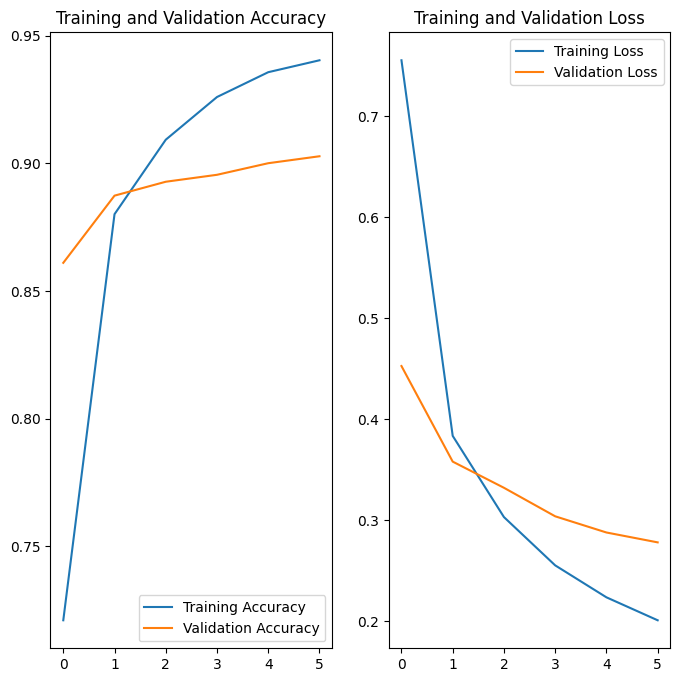

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Generate classification report.

In [ ]:
X_train = list(map(lambda x: x[1], validation_set))

preds = model_inception.predict(validation_batches,verbose=1)

pred = np.array([np.argmax(i) for i in preds])
pred[:5]

actual = list(map(lambda x: x[1], validation_set))
actual = np.array(actual)

print(classification_report(pred,actual))

35/35 [==============================] - 5s 114ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       259
           1       0.90      0.95      0.93       177
           2       0.88      0.89      0.89       265
           3       0.91      0.90      0.90       205
           4       0.89      0.83      0.86       195

    accuracy                           0.90      1101
   macro avg       0.90      0.90      0.90      1101
weighted avg       0.90      0.90      0.90      1101

